In [1]:
from scipy import io
from netCDF4 import MFDataset,Dataset,num2date,date2num
import numpy as np
import datetime as dt
import xarray as xr
import pandas as pd
from numpy import ma
import os

pth='D:/JMA/CHA_MAT/'
wnpth='J:/Obs/myISHII_198001_201912_ts.nc'

d_lst=[pth+i for i in os.listdir(pth) if i.endswith('mat')]

Sample=io.loadmat(d_lst[0])
LAT,LON=Sample['lat'],Sample['lon']
DEPTH=np.flipud(Sample['depth'])
### Read mat files =================================================
TEMP=np.zeros([len(d_lst)*12,len(DEPTH),len(LAT),len(LON)])
SALT=np.zeros_like(TEMP)
for i,fac in zip(d_lst,range(len(d_lst))):
    tmp=io.loadmat(i)
    TEMP[fac*12:(fac+1)*12,:,:,:]=tmp['temp']
    SALT[fac*12:(fac+1)*12,:,:,:]=tmp['salt']

### Create time num =================================================
TIMES=pd.date_range('1980-01','2020-01',freq='M').strftime('%Y%m')
Ref_time='days since 1970-1-1 00:00:00'
my_time_num=date2num([dt.datetime(int(str(i)[:4]),int(str(i)[4:6]),15)\
    for i in TIMES],Ref_time)

### Data Masking ====================================================
mask=(TEMP!=TEMP).data
TEMP=ma.array(TEMP,mask=mask)
mask=(SALT!=SALT).data
SALT=ma.array(SALT,mask=mask)
TEMP,SALT=np.flip(TEMP,axis=1),np.flip(SALT,axis=1)

In [8]:
DEPTH

array([[   0.],
       [  10.],
       [  20.],
       [  30.],
       [  50.],
       [  75.],
       [ 100.],
       [ 125.],
       [ 150.],
       [ 200.],
       [ 250.],
       [ 300.],
       [ 400.],
       [ 500.],
       [ 600.],
       [ 700.],
       [ 800.],
       [ 900.],
       [1000.],
       [1100.],
       [1200.],
       [1300.],
       [1400.],
       [1500.],
       [1750.],
       [2000.],
       [2500.],
       [3000.]], dtype=float32)

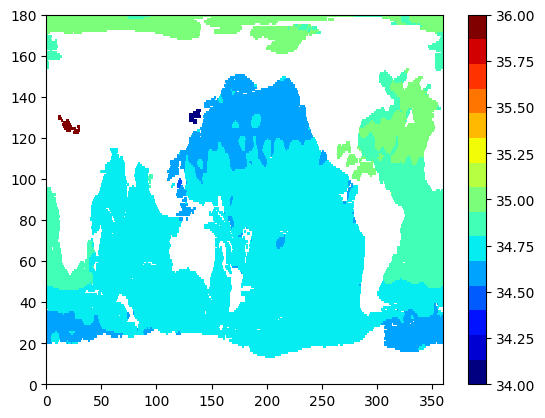

In [7]:
import matplotlib.pyplot as plt
plt.pcolor(A[0][0],vmin=34,vmax=36,cmap=plt.get_cmap('jet',15))
plt.colorbar()

In [1]:
import matplotlib.pyplot as plt
import gsw.density as gsw_d
import gsw.conversions as gsw_c
from gsw._wrapped_ufuncs import cp_t_exact
import xarray as xr
from netCDF4 import Dataset
import os
from numpy import ma
import numpy as np

npth='J:/Obs/myIAP_198001_201812_tsuv.nc'

DATA=xr.open_dataset(npth).loc[dict(depth=slice(0,2000))]

DEPTH,LAT,LON=DATA.depth,DATA.lat,DATA.lon 
SA,TEMP=DATA.salt,DATA.temp


'''
All values --> xarray.dataarray 
'''

    # SA = gsw_c.SA_from_SP(SA,DEPTH,LON,LAT) # [SA, in_ocean] = gsw_SA_from_SP(SP,p,long,lat)

# Potential temp --> Conservative temp
CT=gsw_c.CT_from_pt(SA,TEMP) #CT = gsw_CT_from_pt(SA,pt)
rho = gsw_d.rho(SA,CT,DEPTH)

# Potential temperature --> In-situ temperature
t=gsw_c.t_from_CT(SA,CT,DEPTH)

# Heat capacity
CP = cp_t_exact(SA,t,DEPTH)

CP,CT,rho=CP.values,CT.values,rho.values
CP=(CP[:,1:,:,:]+CP[:,:-1,:,:])/2
CT=(CT[:,1:,:,:]+CT[:,:-1,:,:])/2


rho=(rho[:,1:,:,:]+rho[:,:-1,:,:])/2

DZ=np.diff(DEPTH)

T,D,A,O=CT.shape

dz=np.tile(np.tile(np.tile(DZ.reshape([D,1]), A )\
                .reshape([D,A,-1]), O), (T,1,1,1) )
raise
OHC_=CP*CT*rho*dz

# Integrates from ref depth (2000m) 
OHC=np.sum(OHC_,axis=1)

   

OHC=calc_ohc(DEPTH,LAT,LON,SA,TEMP,Abs_salt=True)
mask=(OHC!=OHC).data
OHC=ma.array(OHC,mask=mask)

del DATA

NC=Dataset(npth,'a')
myOHC = NC.createVariable('OHC_700',np.float64,('time','lat','lon'),compression='zlib') #
myOHC.units = 'Jm^-2' 
myOHC.long_name = 'ISHII OHC 700' 
myOHC.coordinates = "time, lat, lon"
myOHC[:]=OHC
NC.close()



c:\Users\shjo\miniconda3\envs\nemo_env\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\shjo\miniconda3\envs\nemo_env\lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: overflow encountered in rho
  result_data = func(*input_data)
c:\Users\shjo\miniconda3\envs\nemo_env\lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in rho
  result_data = func(*input_data)
c:\Users\shjo\miniconda3\envs\nemo_env\lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: overflow encountered in t_from_ct
  result_data = func(*input_data)
c:\Users\shjo\miniconda3\envs\nemo_env\lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in t_from_ct
  result_data = func(*input_data)


RuntimeError: No active exception to reraise

In [48]:
A=CT[0,0,:,:]-TEMP[0,0,:,:]

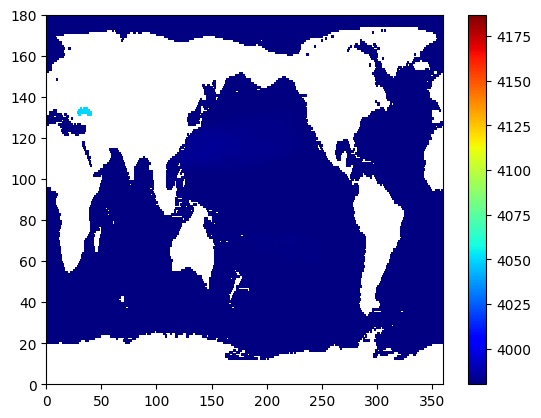

In [33]:
plt.pcolor(CP[0,20,:,:],vmin=3980,vmax=4187,cmap=plt.get_cmap('jet'))
plt.colorbar()

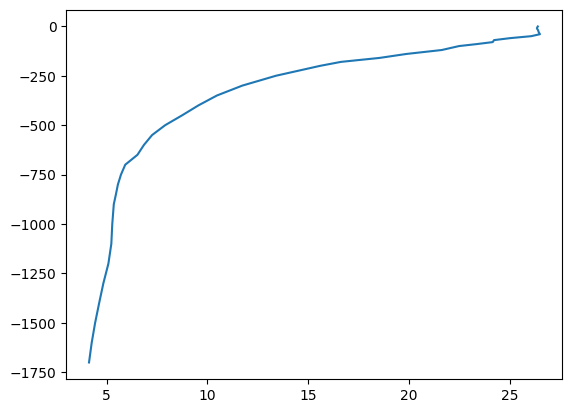

In [32]:
plt.plot(t[0,:,100,300],-DEPTH)

In [8]:
dz[100,:,100,300]

array([  4.,   5.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
        20.,  20.,  20.,  20.,  20.,  50.,  50.,  50.,  50.,  50.,  50.,
        50.,  50.,  50.,  50.,  50.,  50.,  50.,  50., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 200.], dtype=float32)

In [11]:
np.diff(DEPTH)

array([  4.,   5.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
        20.,  20.,  20.,  20.,  20.,  50.,  50.,  50.,  50.,  50.,  50.,
        50.,  50.,  50.,  50.,  50.,  50.,  50.,  50., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 200.], dtype=float32)

In [5]:
CP=(CP[:,1:,:,:]+CP[:,:-1,:,:])/2
CT=(CT[:,1:,:,:]+CT[:,:-1,:,:])/2


rho=(rho[:,1:,:,:]+rho[:,:-1,:,:])/2

DZ=np.diff(DEPTH)

T,D,A,O=CT.shape

dz=np.tile(np.tile(np.tile(DZ.reshape([D,1]), A )\
                .reshape([D,A,-1]), O), (T,1,1,1) )

ValueError: cannot reshape array of size 40 into shape (39,1)

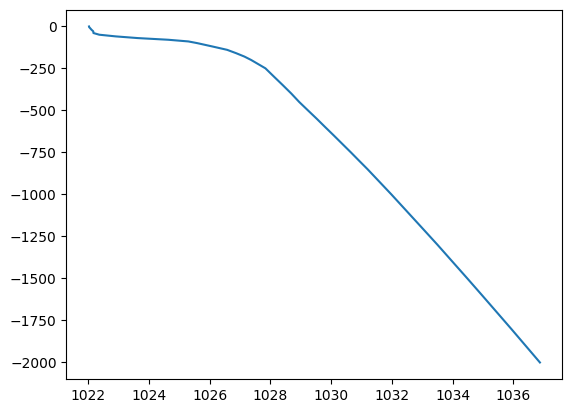

In [2]:
plt.plot(rho[0,:,100,200],-DEPTH.values)

In [32]:
rho[0,:,100,200]

array([1022.02451733, 1022.02901203, 1022.05633195, 1022.1036957 ,
       1022.16467028, 1022.17007769, 1022.3624503 , 1022.90588023,
       1023.62714586, 1024.63536687, 1025.29731432, 1025.58783236,
       1026.08843613, 1026.57496507, 1026.87176927, 1027.14292483,
       1027.36226901, 1027.8357473 , 1028.11999074, 1028.40720862,
       1028.68770321, 1028.94745056, 1029.23545594, 1029.52602085,
       1029.80639141, 1030.09129189, 1030.37045483, 1030.65061951])

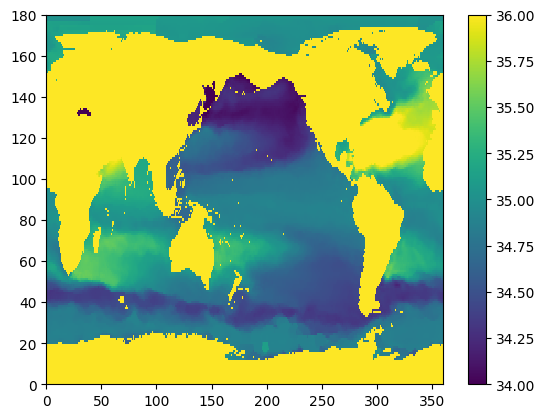

In [37]:
plt.pcolor(SA[0,20,:,:],vmin=34,vmax=36)
plt.colorbar()

In [30]:
rho = gsw_d.rho(SA,CT,DEPTH)

array([[[[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         ...,
         [1023.94190388, 1023.94873513, 1023.95621526, ...,
          1023.91053624, 1023.9243484 , 1023.93491195],
         [1024.07712287, 1024.07828914, 1024.07898289, ...,
          1024.05573967, 1024.06704531, 1024.0743056 ],
         [1023.82810268, 1023.82852758, 1023.82871035, ...,
          1023.82229498, 1023.82806256, 1023.83091988]],

        [[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, .